<a href="https://colab.research.google.com/github/martin-fabbri/colab-notebooks/blob/master/deeplearning.ai/tf/c4_w2_time_series_prediction_linear_regresion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time Series Prediction - NN Single Layer (linear regresion)

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

2.3.0


In [2]:
def plot_series(time, series, format='-', start=0, end=None):
  plt.plot(time[start:end], series[start:end], format)
  plt.xlabel('Time')
  plt.ylabel('Value')
  plt.grid(True)

def trend(time, slope=0):
  return slope * time

def seasonal_pattern(season_time):
  '''
  Just an arbitrary patten, you can change it if you wish
  '''
  return np.where(
      season_time < 0.4,
      np.cos(season_time * 2 * np.pi),
      1 / np.exp(3 * season_time)
  )

def seasonality(time, period, amplitude=1, phase=0):
  '''
  Repeats the same pattern at each period
  '''
  season_time = ((time + phase) % period) / period
  return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
  rnd = np.random.RandomState(seed)
  return rnd.randn(len(time)) * noise_level

In [3]:
baseline = 10
slope = 0.05
amplitude = 40
noise_level = 5
time = np.arange(4 * 365 + 1, dtype='float32')
trend_series = trend(time, slope)
seasonality_series = seasonality(time, period=365, amplitude=amplitude)
noise_series = noise(time, noise_level, seed=42)

series = baseline + trend_series + seasonality_series + noise_series

In [4]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

In [5]:
window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [9]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(
      lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [13]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
dataset

<PrefetchDataset shapes: ((None, None), (None,)), types: (tf.float64, tf.float64)>

In [15]:
l0 = tf.keras.layers.Dense(1, input_shape=[window_size])
model = tf.keras.Sequential([l0])

model.compile(
    loss='mse',
    optimizer = tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9)
)

model.fit(dataset, epochs=100, verbose=0)
print('layer weights:', l0.get_weights())

layer weights: [array([[-0.0812099 ],
       [ 0.01200222],
       [ 0.0761575 ],
       [-0.0377769 ],
       [ 0.00939761],
       [ 0.04461161],
       [-0.01096641],
       [-0.00612783],
       [-0.00133137],
       [-0.03213766],
       [-0.00554723],
       [ 0.04165699],
       [-0.03591018],
       [ 0.00671165],
       [-0.02954551],
       [ 0.1409856 ],
       [-0.00074366],
       [ 0.21783128],
       [ 0.19409691],
       [ 0.47115174]], dtype=float32), array([0.01679779], dtype=float32)]


In [16]:
forecast = []
for time in range(len(series) - window_size):
  prediction = model.predict(series[time: time + window_size][np.newaxis])
  forecast.append(prediction)

forecast = forecast[split_time - window_size:]
results = np.array(forecast)[:, 0, 0]

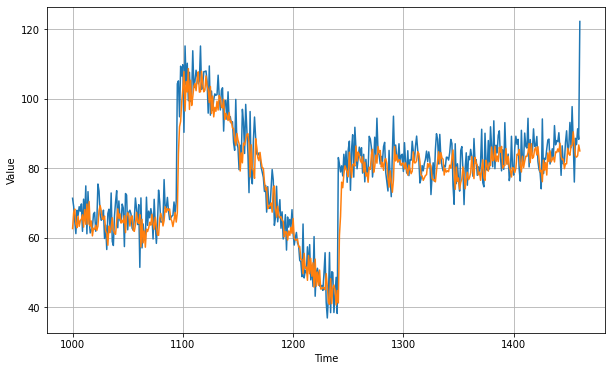

In [17]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [18]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

5.1829886